In [1]:
import warnings
warnings.filterwarnings('ignore')
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot

In [2]:
df = pd.read_excel('Data/all_data.xlsx')

In [3]:
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [4]:
df = df.drop(columns=['Date', 'Volume', 'Sentimen', 'Index', 'Adj_Close'])

In [5]:
X = df.drop('Close', axis=1)
y = df['Close']

In [6]:
X, y, scaler = scale_data(df)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test):
    model = Sequential()    
    try:
        if n_lstm == 1:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif n_lstm == 2:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
        elif n_lstm == 3:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
            model.add(LSTM(units=neuron))
        else:
            print("Invalid LSTM configuration")

        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test))

        return history 
    except Exception as e:
        print(f"Error during model training: {e}")
        return None 

def tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs):
    results = {} 

    for n_lstm in lstm_configs['n_lstm']:
        for neuron in lstm_configs['neurons']:
            for epoch in lstm_configs['epochs']:
                print(f'Running trial with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch}')
                key = f'n_lstm={n_lstm}_neurons={neuron}_epochs={epoch}'
                history = declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test)
                
                if history is not None:
                    mse_train = history.history['loss'][-1] 
                    mse_test = history.history['val_loss'][-1]
                    results[key] = {'history': history.history, 'mse_train': mse_train, 'mse_test': mse_test}
                else:
                    print(f"Skipping combination n_lstm={n_lstm}, neuron={neuron}, epoch={epoch} due to error")

    return results

lstm_configs = {
    'n_lstm': [1, 2],  
    'neurons': [50, 100, 150, 200],  
    'epochs': [10, 20, 30] 
}

In [9]:
results = tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs)

Running trial with n_lstm=1, neuron=50, epoch=10
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 292 samples, validate on 73 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
292/292 [==============================] - 1s 2ms/sample - loss: 0.0372 - val_loss: 0.1089
Epoch 2/10
292/292 [==============================] - 0s 88us/sample - loss: 0.0150 - val_loss: 0.0409
Epoch 3/10
292/292 [==============================] - 0s 90us/sample - loss: 0.0152 - val_loss: 0.0845
Epoch 4/10
292/292 [==============================] - 0s 94us/sample - loss: 0.0133 - val_loss: 0.1023
Epoch 5/10
292/292 [==============================] - 0s 95us/sample - loss: 0.0131 - val_loss: 0.0922
Epoch 6/10
292/292 [==============================] - 0s 95us/sample - loss: 0.0129 - val_loss: 0.1028
Epoch 7/10
292/292 [==============================] - 0s 92us/sample - loss: 

In [10]:
hasil = []

for key, value in results.items():
    mse_train = value['mse_train']
    mse_test = value['mse_test']
    hasil.append({
        'experiment': key,
        'mse_train': mse_train,
        'mse_test': mse_test
    })

hp_lstm = pd.DataFrame(hasil)

for result in hasil:
    print(f"Experiment: {result['experiment']}, MSE Train: {result['mse_train']}, MSE Test: {result['mse_test']}")

Experiment: n_lstm=1_neurons=50_epochs=10, MSE Train: 0.012487366814676621, MSE Test: 0.12354026571528552
Experiment: n_lstm=1_neurons=50_epochs=20, MSE Train: 0.012360870838165283, MSE Test: 0.1426638274976652
Experiment: n_lstm=1_neurons=50_epochs=30, MSE Train: 0.012300823878956167, MSE Test: 0.13822170663369845
Experiment: n_lstm=1_neurons=100_epochs=10, MSE Train: 0.012570701054718397, MSE Test: 0.11900566079436917
Experiment: n_lstm=1_neurons=100_epochs=20, MSE Train: 0.012279803328828453, MSE Test: 0.11823547509026854
Experiment: n_lstm=1_neurons=100_epochs=30, MSE Train: 0.01256698949823845, MSE Test: 0.13344630374483865
Experiment: n_lstm=1_neurons=150_epochs=10, MSE Train: 0.012513845846414158, MSE Test: 0.11857451937378269
Experiment: n_lstm=1_neurons=150_epochs=20, MSE Train: 0.012459196405459757, MSE Test: 0.1422511594344492
Experiment: n_lstm=1_neurons=150_epochs=30, MSE Train: 0.012427700964147097, MSE Test: 0.1402608384824779
Experiment: n_lstm=1_neurons=200_epochs=10, 

In [11]:
hp_lstm

,experiment,mse_train,mse_test
0,n_lstm=1_neurons=50_epochs=10,0.012487,0.123540
1,n_lstm=1_neurons=50_epochs=20,0.012361,0.142664
2,n_lstm=1_neurons=50_epochs=30,0.012301,0.138222
3,n_lstm=1_neurons=100_epochs=10,0.012571,0.119006
4,n_lstm=1_neurons=100_epochs=20,0.012280,0.118235
5,n_lstm=1_neurons=100_epochs=30,0.012567,0.133446
6,n_lstm=1_neurons=150_epochs=10,0.012514,0.118575
7,n_lstm=1_neurons=150_epochs=20,0.012459,0.142251
8,n_lstm=1_neurons=150_epochs=30,0.012428,0.140261
9,n_lstm=1_neurons=200_epochs=10,0.012565,0.120411


In [12]:
hp_lstm.to_excel("kombinasi-parameter-2.xlsx")

In [13]:
max_mse_train_index = hp_lstm['mse_train'].idxmin()
max_mse_train_row = hp_lstm.loc[max_mse_train_index]
print(max_mse_train_row)

experiment    n_lstm=2_neurons=150_epochs=30
mse_train                           0.000329
mse_test                            0.001125
Name: 20, dtype: object


In [14]:
max_mse_test_index = hp_lstm['mse_test'].idxmin()
max_mse_test_row = hp_lstm.loc[max_mse_test_index]
print(max_mse_test_row)

experiment    n_lstm=2_neurons=100_epochs=30
mse_train                           0.000362
mse_test                            0.001117
Name: 17, dtype: object


In [53]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=100))
model.add(Dense(25))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test))

Train on 292 samples, validate on 73 samples
Epoch 1/30
292/292 [==============================] - 6s 20ms/sample - loss: 0.0395 - val_loss: 0.1701
Epoch 2/30
292/292 [==============================] - 0s 272us/sample - loss: 0.0093 - val_loss: 0.0388
Epoch 3/30
292/292 [==============================] - 0s 270us/sample - loss: 0.0095 - val_loss: 0.0700
Epoch 4/30
292/292 [==============================] - 0s 268us/sample - loss: 0.0065 - val_loss: 0.0860
Epoch 5/30
292/292 [==============================] - 0s 278us/sample - loss: 0.0051 - val_loss: 0.0362
Epoch 6/30
292/292 [==============================] - 0s 270us/sample - loss: 0.0035 - val_loss: 0.0212
Epoch 7/30
292/292 [==============================] - 0s 269us/sample - loss: 0.0018 - val_loss: 0.0073
Epoch 8/30
292/292 [==============================] - 0s 266us/sample - loss: 6.9999e-04 - val_loss: 0.0012
Epoch 9/30
292/292 [==============================] - 0s 268us/sample - loss: 3.5708e-04 - val_loss: 0.0018
Epoch 10/30


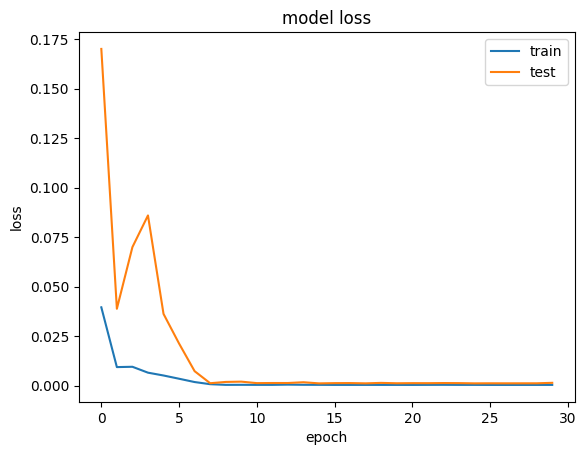

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [55]:
predictions_train = model.predict(X_train)

inverse_predictions_train = inverse_transform(scaler, predictions_train)
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

,Predicted,Actual
0,24002.815213,23475.466797
1,24132.011080,22362.679688
2,23677.309844,22353.349609
3,22992.057321,22435.513672
4,23097.175100,22429.757813


In [56]:
predictions_test = model.predict(X_test)

inverse_predictions_test = inverse_transform(scaler, predictions_test)
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.head()

,Predicted,Actual
0,42347.312948,42270.527344
1,43471.108396,43652.250000
2,43882.289799,43869.152344
3,44694.220281,43997.902344
4,44857.114373,43739.542969


# METRIKS EVALUASI

In [57]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 839.6313049449058
Root Mean Squared Error (RMSE) Test Set: 1577.3082014627573

R-squared Train Set: 0.9679844055071427
R-squared Test Set: 0.8943932497521786


# VISUALISASI

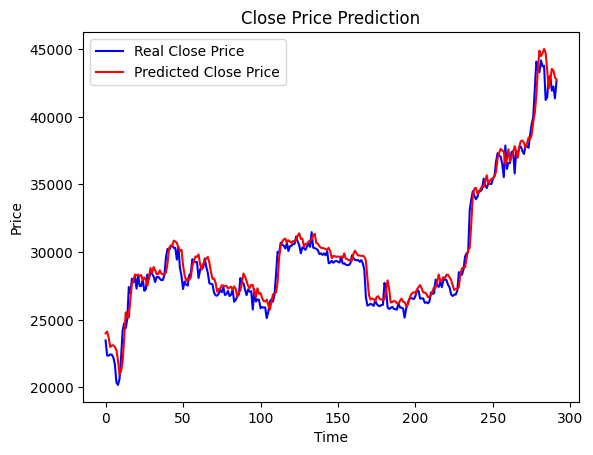

In [58]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)


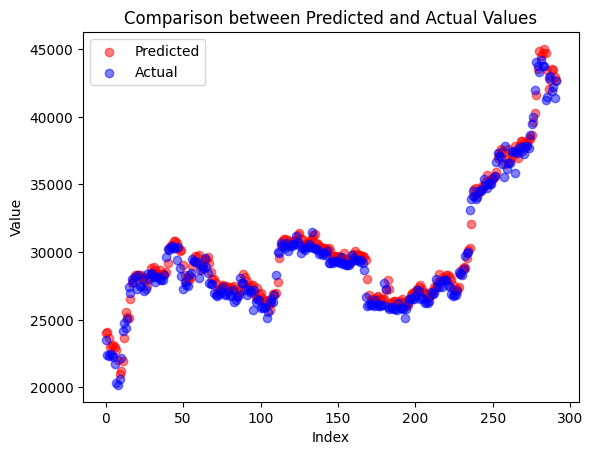

In [59]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)


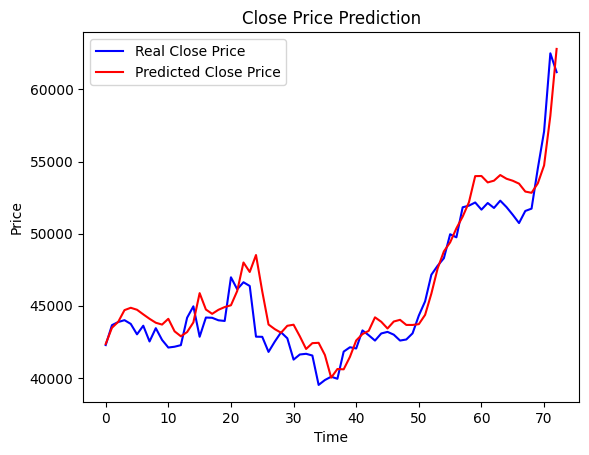

In [60]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

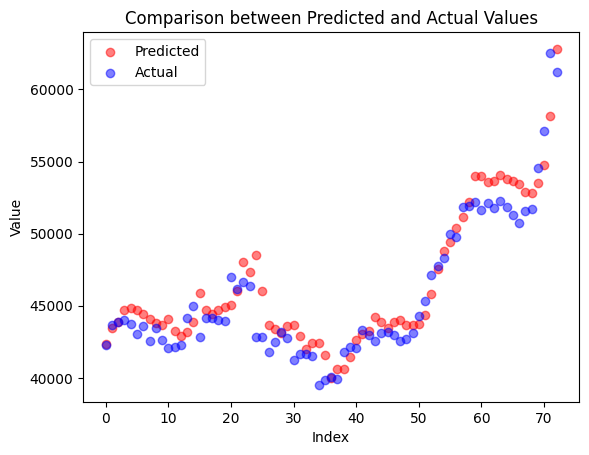

In [61]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [62]:
X_train.shape

(292, 1, 3)

In [63]:
X_test.shape

(73, 1, 3)

In [64]:
features = ["Open", "High", "Low"]

explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)